In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

import kagglehub
from kagglehub import KaggleDatasetAdapter



In [3]:
file_path = "credit_risk_dataset.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "laotse/credit-risk-dataset",file_path
)

In [4]:
print("Original Dataset shape:", df.shape)
print(df.head())

Original Dataset shape: (32581, 12)
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                     

In [5]:
TARGET_COL = "loan_status"
RANDOM_STATE = 42
N_SPLITS = 5
DEFAULT_LGD = 0.45
DEFAULT_EAD = 1.0

In [6]:
y = df[TARGET_COL].astype(int)
X = df.drop(columns=[TARGET_COL])

cat_cols = [c for c in X.columns if X[c].dtype =="object" or str(X[c].dtype).startswith("category")]
num_cols = [c for c in X.columns if c not in cat_cols]

print("Categorical columns: ", cat_cols)
print("Numerical columns: ", num_cols)

Categorical columns:  ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
Numerical columns:  ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


In [7]:
too_many_nans = [c for c in X.columns if X[c].isna().mean() > 0.95]
X = X.drop(columns=too_many_nans)
cat_cols = [c for c in cat_cols if c not in too_many_nans]
num_cols = [c for c in num_cols if c not in too_many_nans]

In [9]:
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

#Check preprocessing output shape
X_transformed = preprocess.fit_transform(X)
print("New shape: ", X_transformed.shape)
print("Sample row (first 5): ", X_transformed[:5, :5])

New shape:  (32581, 11)
Sample row (first 5):  [[-9.03373832e-01 -1.14143288e-01  2.89266135e+01  4.01940376e+00
   1.62592119e+00]
 [-1.06090423e+00 -9.11146711e-01  5.67626247e-02 -1.35864998e+00
   4.23096785e-02]
 [-4.30782625e-01 -9.11146711e-01 -9.21876389e-01 -6.46848753e-01
   6.03712940e-01]
 [-7.45843430e-01 -9.27441697e-03 -1.87897129e-01  4.01940376e+00
   1.36955785e+00]
 [-5.88313028e-01 -1.88358182e-01  7.90741885e-01  4.01940376e+00
   1.05802772e+00]]


In [10]:
models = {
    "KNN": Pipeline([
        ("prep", preprocess),
        ("clf", KNeighborsClassifier(n_neighbors=15, weights = "distance"))
    ]),
    "LogReg": Pipeline([
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=200))
    ])
}

In [11]:
try:
  from xgboost import XGBClassifier
  models["XGBoost"] = Pipeline([
      ("prep", preprocess),
      ("clf", XGBClassifier(
          n_estimators=300,
          learning_rate=0.05,
          max_depth = 5,
          subsample=0.9,
          colsample_bytree=0.9,
          random_state=RANDOM_STATE,
          eval_metric="auc",
          tree_method="hist",
          n_jobs=-1
      ))
  ])
except ImportError:
  print("XGBoost not installed")

KNN : Mean ROC-AUV = 0.8828
LogReg : Mean ROC-AUV = 0.8489
XGBoost : Mean ROC-AUV = 0.9456


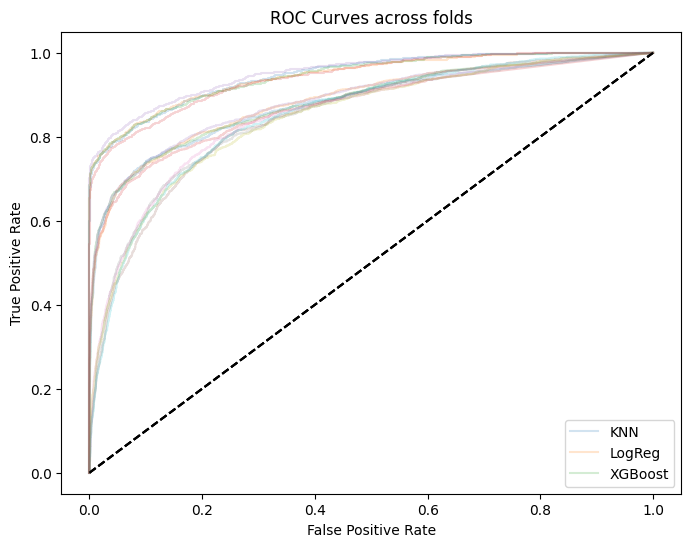


Best model:  XGBoost


In [12]:
#Evaluations

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
cv_results={}
plt.figure(figsize=(8,6))

for name,pipe in models.items():
  tprs, aucs =[],[]
  mean_fpr = np.linspace(0, 1, 100)

  for tr_idx, va_idx in skf.split(X,y):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    pipe.fit(X_tr, y_tr)
    va_proba = pipe.predict_proba(X_va)[:, 1]

    auc = roc_auc_score(y_va, va_proba)
    aucs.append(auc)

    fpr, tpr, _ = roc_curve(y_va, va_proba)
    plt.plot(fpr,tpr,alpha=0.2)

  mean_auc = np.mean(aucs)
  cv_results[name] = mean_auc
  print(f"{name} : Mean ROC-AUV = {mean_auc:.4f}")

  plt.plot([0,1],[0,1], "k--")
  plt.title("ROC Curves across folds")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(list(models.keys()))
plt.show()

best_model_name = max(cv_results.items(), key=lambda kv: kv[1])[0]
print("\nBest model: ", best_model_name)
best_model = models[best_model_name].fit(X,y)

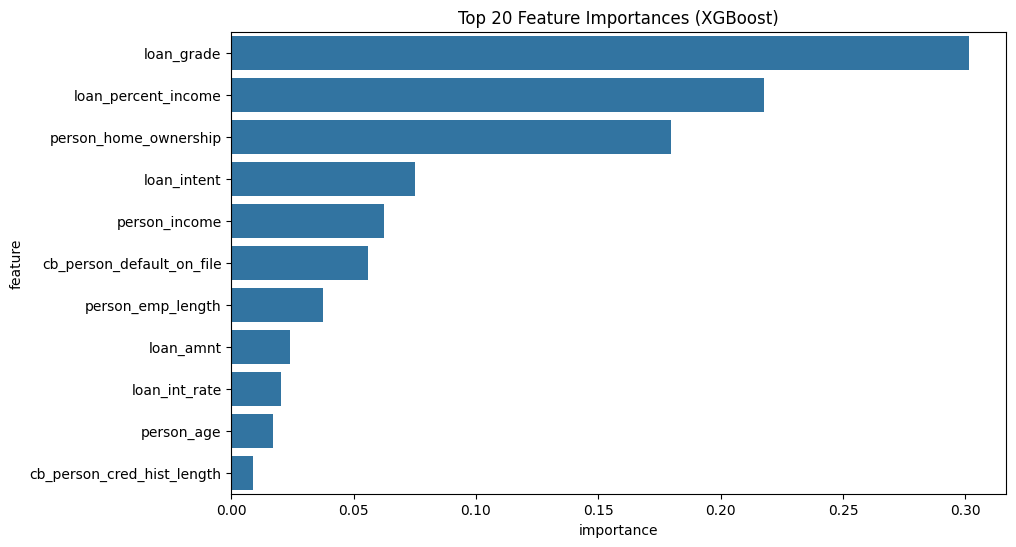

In [13]:
try:
  if best_model_name == "XGBoost":
    xgb = best_model.named_steps["clf"]
    importances = xgb.feature_importances_
    feat_names = num_cols + cat_cols
    fi_df = pd.DataFrame({"feature": feat_names, "importance": importances})
    fi_df = fi_df.sort_values("importance", ascending=False).head(20)
    plt.figure(figsize=(10,6))
    sns.barplot(x="importance", y="feature", data=fi_df)
    plt.title("Top 20 Feature Importances (XGBoost)")
    plt.show()
  else:
    result = permutation_importance(best_model, X.iloc[:1000], y.iloc[:1000],
                                    scoring="roc_auc", n_repeats=5, random_state=RANDOM_STATE)
    feat_names = num_cols + cat_cols
    fi_df = pd.DataFrame({
        "feature": feat_names,
        "importance": result.importances_mean
    }).sort_values("importance",ascending=False).head(20)
    plt.figure(figsize=(10,6))
    sns.barplot(x="importance", y="feature", data=fi_df)
    plt.title("Top 20 Feature Importance (Permutation)")
    plt.show()
except Exception as e:
  print("Feature importance skipped: ", e)

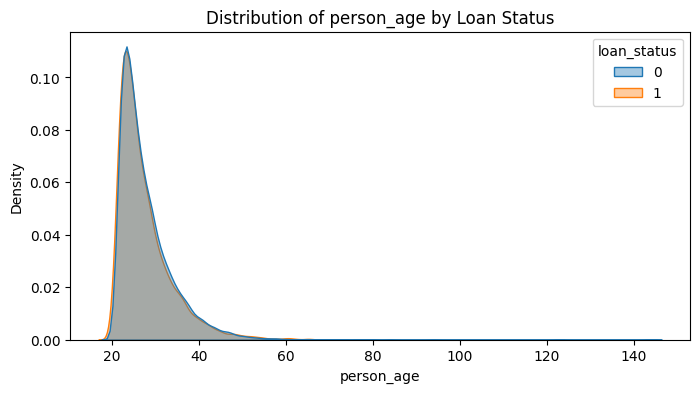

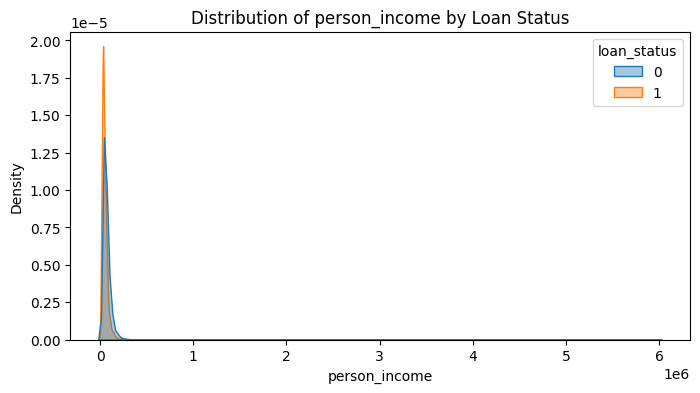

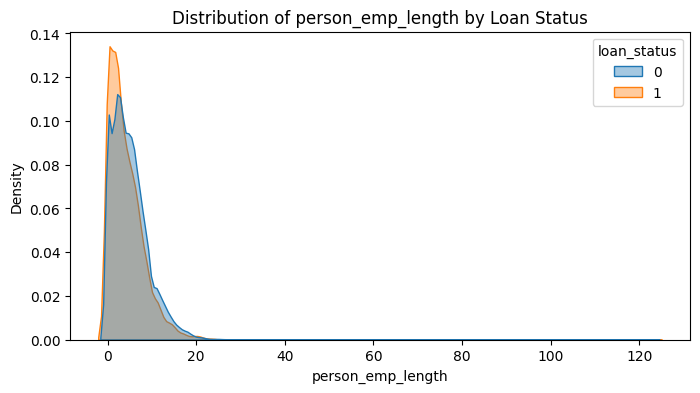

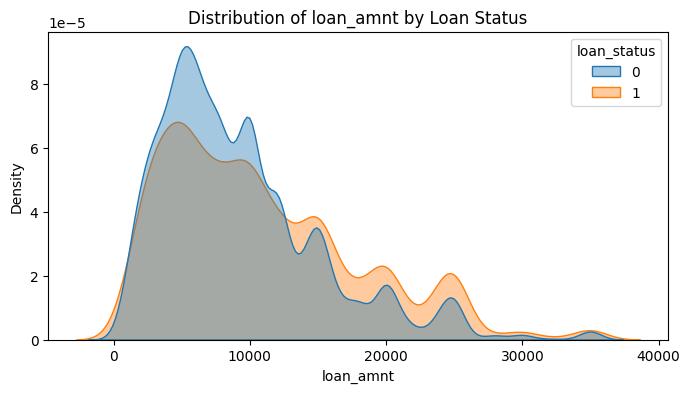

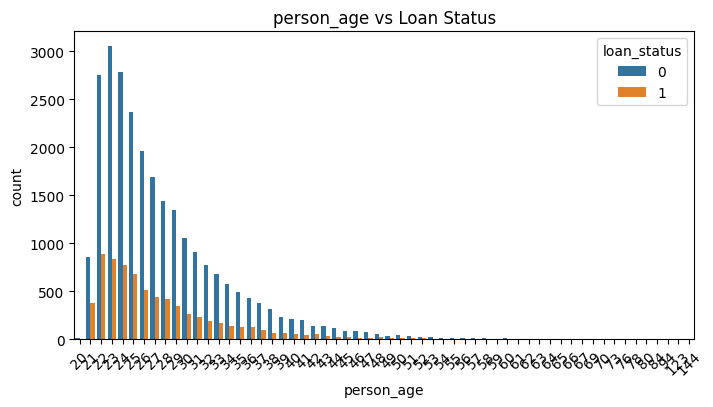

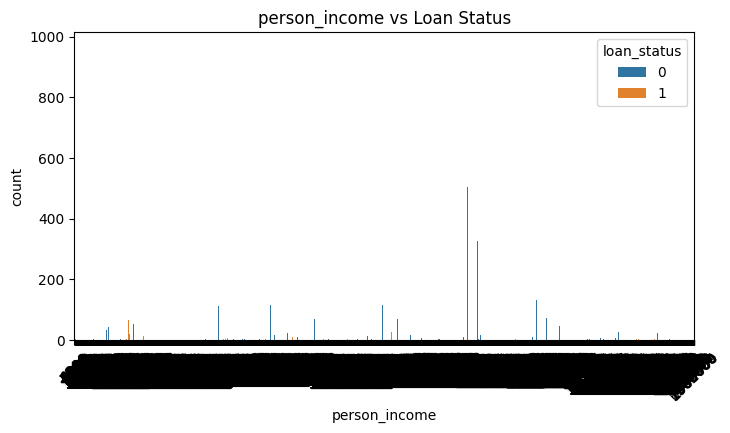

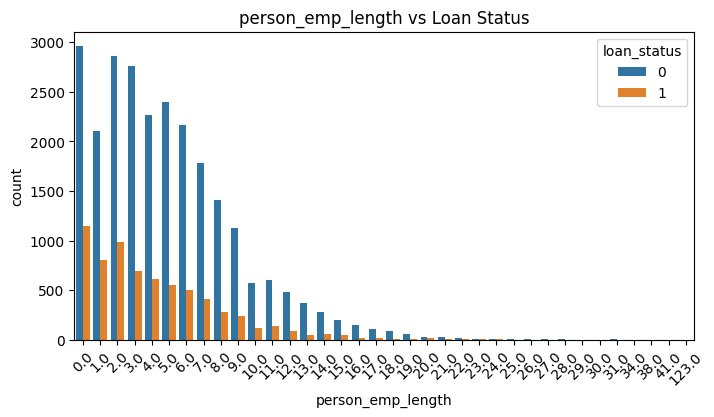

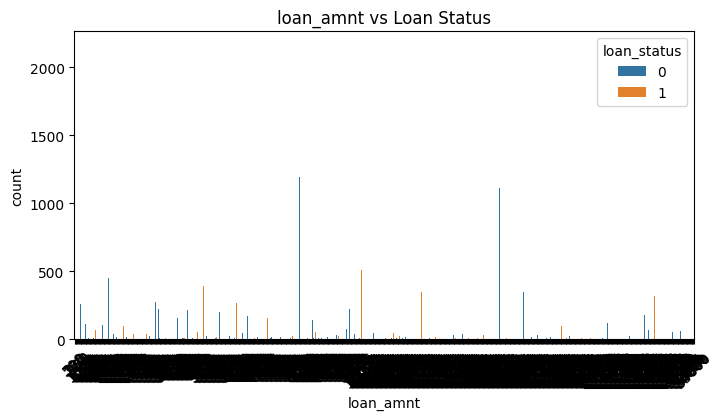

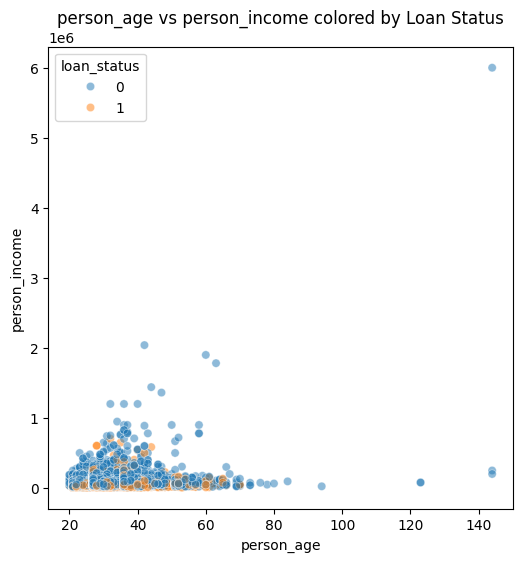

In [14]:
#EDA

#Numeric distribution by loan_status
for col in num_cols[:4]:
  plt.figure(figsize=(8,4))
  sns.kdeplot(data=df, x=col, hue=TARGET_COL, fill=True, common_norm=False, alpha=0.4)
  plt.title(f"Distribution of {col} by Loan Status")
  plt.show()

#categorical vs default rate
for col in num_cols[:4]:
  plt.figure(figsize=(8,4))
  sns.countplot(data=df, x=col, hue=TARGET_COL)
  plt.title(f"{col} vs Loan Status")
  plt.xticks(rotation=45)
  plt.show()

#scatter plot for two numeric features
if len(num_cols) >= 2:
  plt.figure(figsize=(6,6))
  sns.scatterplot(data=df, x=num_cols[0], y=num_cols[1], hue=TARGET_COL, alpha=0.5)
  plt.title(f"{num_cols[0]} vs {num_cols[1]} colored by Loan Status")
  plt.show()


Top correlatons with loan_status:
 loan_percent_income           0.379366
loan_int_rate                 0.335133
loan_amnt                     0.105376
cb_person_cred_hist_length   -0.015529
person_age                   -0.021629
person_emp_length            -0.082489
person_income                -0.144449
Name: loan_status, dtype: float64

Lowest correlations with loan_status:
 loan_percent_income           0.379366
loan_int_rate                 0.335133
loan_amnt                     0.105376
cb_person_cred_hist_length   -0.015529
person_age                   -0.021629
person_emp_length            -0.082489
person_income                -0.144449
Name: loan_status, dtype: float64


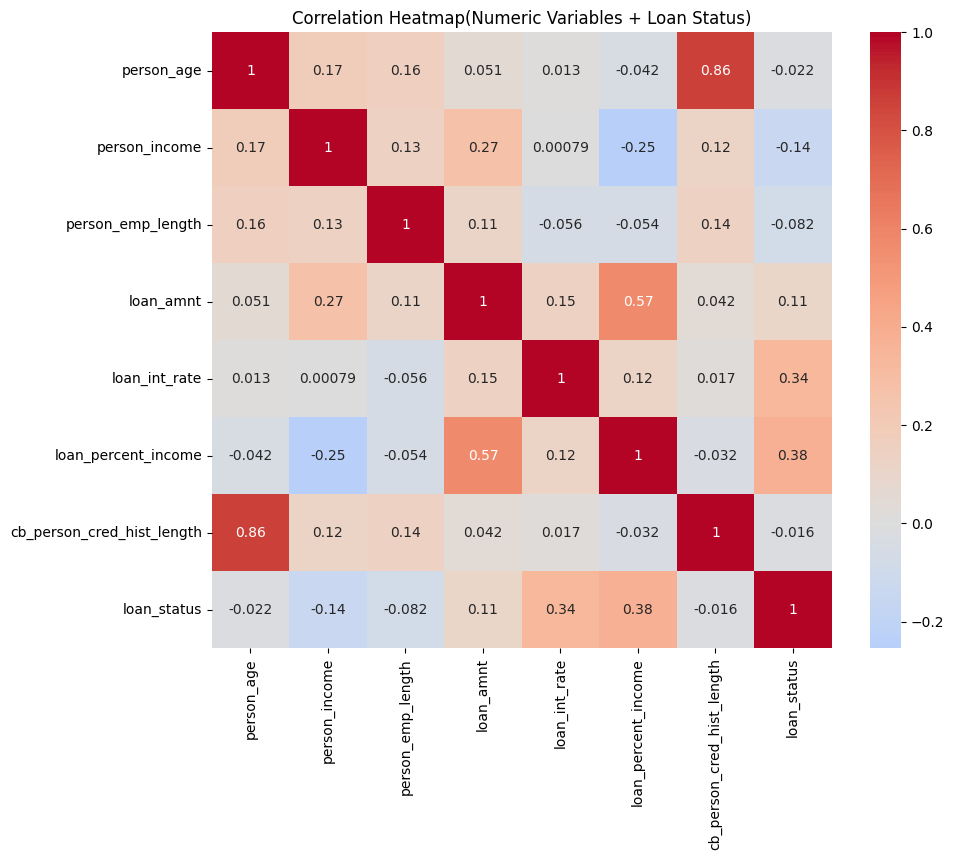

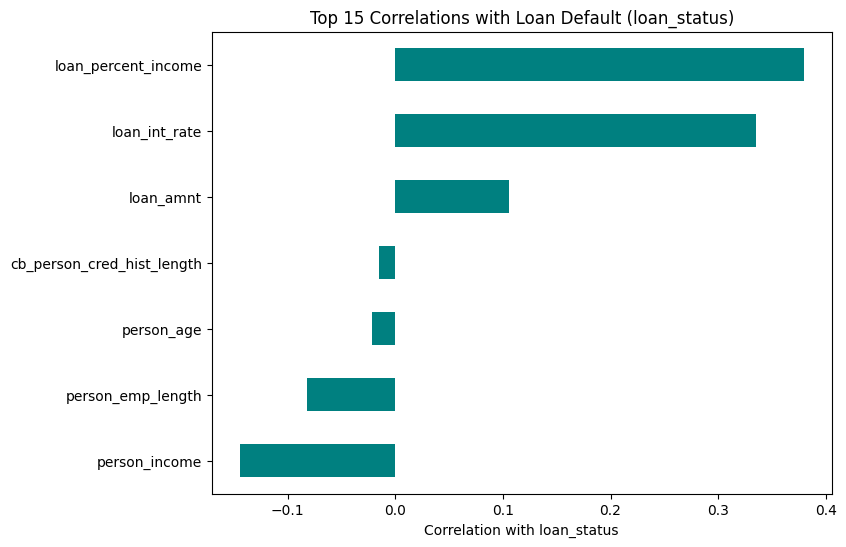

In [16]:
corr_matrix = df[num_cols + [TARGET_COL]].corr()

loan_corr = corr_matrix[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False)

print("\nTop correlatons with loan_status:\n", loan_corr.head(10))
print("\nLowest correlations with loan_status:\n", loan_corr.tail(10))

#Heatmap of all numerical correlations
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap(Numeric Variables + Loan Status)")
plt.show()

#Barplot of correlation with loan_status (top 15)
plt.figure(figsize=(8,6))
loan_corr.head(15).plot(kind="barh", color="teal")
plt.title("Top 15 Correlations with Loan Default (loan_status)")
plt.xlabel("Correlation with loan_status")
plt.gca().invert_yaxis()
plt.show()